# Joint data analysis

This will be the notebook in which I will conduct my joint data analysis.
The idea is that I can use my JOD data as well as my quantitative data from the cluster in order to formulate some joint statements about my model performance.

In [2]:
import pandas as pd

df_jod = pd.read_excel("data/jod.xlsx")
df_metrics = pd.read_excel("data/singleMetricResultClean.xlsx")

### Reflection

So given my JOD values, what kind of correlation could I even compute?

For each facet of my data I can create scatterplot where one observation is a method.

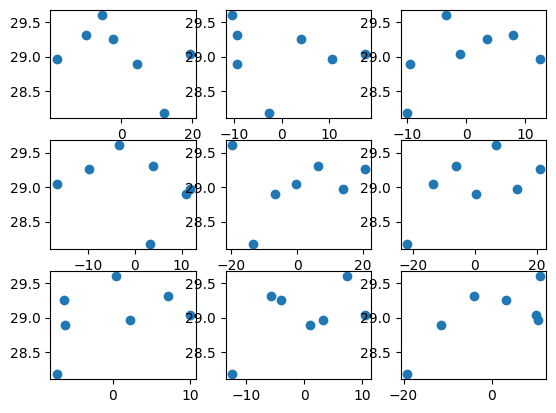

In [ ]:
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, norm, spearmanr
import numpy as np

def compute_spearman(x, y) -> float:
    corr, _ = spearmanr(x, y)
    return corr


def compute_pearsonr(x, y) -> float:
    corr, _ = pearsonr(x, y)
    return corr


def plot_quality_metric_against_jod(quality_metric: str = "psnr") -> pd.DataFrame:
    fig, axs = plt.subplots(3, 3)

    records = []

    for i, dataset in enumerate(df_metrics["dataset"].unique()):
        for j, size in enumerate(["low", "medium", "high"]):
            single_facet_df = (
                df_jod[(df_jod["dataset"] == dataset) & (df_jod["size"] == size)]
                .transpose()
                .iloc[3:]
                .rename(lambda x: "jod", axis=1)
            )
            metric_single_facet = (
                df_metrics[
                    (df_metrics["dataset"] == "room") & (df_metrics["size"] == "low")
                ]
                .groupby(["model", "dataset", "size"])[quality_metric]
                .median()
            )
            metrics_df = pd.DataFrame.from_dict(
                {
                    "technique": [
                        technique.replace("-", "_")
                        for technique, _, _ in metric_single_facet.index
                    ],
                    quality_metric: metric_single_facet.values,
                }
            ).set_index("technique")
            single_facet_df = single_facet_df.join(metrics_df)

            axs[i][j].scatter(single_facet_df["jod"], single_facet_df[quality_metric])

            records.append(
                {
                    "dataset": dataset,
                    "size": size,
                    "SROCC": compute_spearman(
                        single_facet_df["jod"], single_facet_df[quality_metric]
                    ),
                    "PLCC": compute_pearsonr(
                        single_facet_df["jod"].astype(np.float32),
                        single_facet_df[quality_metric].astype(np.float32),
                    ),
                }
            )

    plt.show()

    return pd.DataFrame.from_records(records)


df_psnr = plot_quality_metric_against_jod()

<Axes: ylabel='dataset-size'>

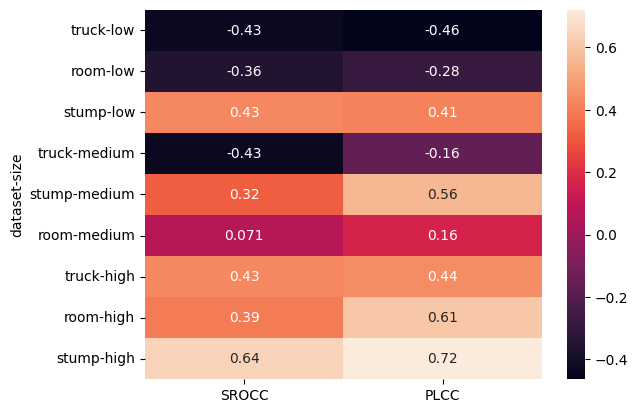

In [78]:
import seaborn as sns


def get_sort_key_for_size(x):
    return x.apply(lambda y: {"high": 3, "medium": 2, "low": 1}[y])


sns.heatmap(
    df_psnr.sort_values("size", key=lambda x: get_sort_key_for_size(x)).set_index(
        ["dataset", "size"]
    ),
    annot=True,
)

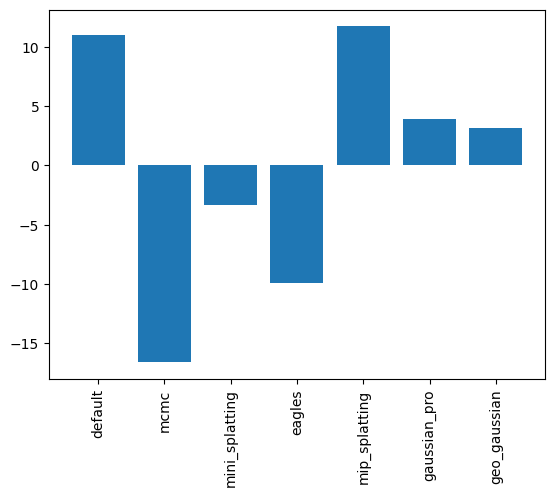

In [17]:
from matplotlib import pyplot as plt

single_facet_df = df_jod[(df_jod["dataset"] == "room") & (df_jod["size"] == "low")].transpose().iloc[3:]

plt.bar(single_facet_df.index, single_facet_df[0])
plt.xticks(rotation=90)
plt.show()


In [25]:
psnr_single_facet = df_metrics[(df_metrics["dataset"] == "room") & (df_metrics["size"] == "low")].groupby(["model", "dataset", "size"])["psnr"].median()

In [26]:
psnr_single_facet

model           dataset  size
default         room     low     28.8986
eagles          room     low     29.2611
gaussian-pro    room     low     29.3104
geo-gaussian    room     low     28.1784
mcmc            room     low     29.0389
mini-splatting  room     low     29.6086
mip-splatting   room     low     28.9718
Name: psnr, dtype: float64

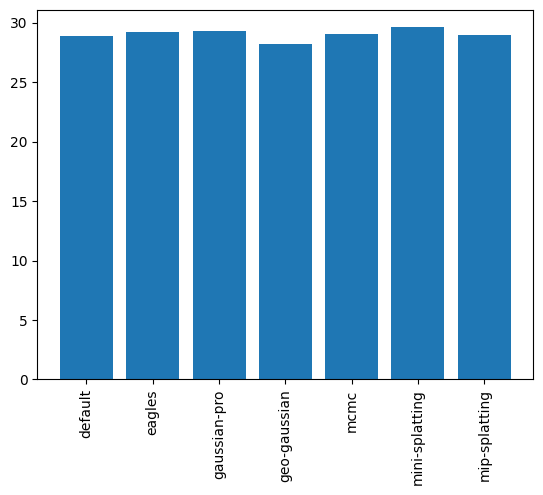

In [35]:
plt.bar([technique for technique, _ , _ in psnr_single_facet.index], psnr_single_facet.values)
plt.xticks(rotation=90)
plt.show()